In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 1 -- NER from Scratch

In [60]:
data = pd.read_csv('./data/ner_dataset.csv', encoding='latin1')

In [62]:
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


Words in range `data.iloc[:24]` are from sentence 1.

We can fill the rows with NaN value at column `Sentence #` to follow its previous value.

In [210]:
data = data.fillna(method='ffill')
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [211]:
words = list(set(data['Word'].values))
n_words = len(words)
n_words

35178

Now with this data, we can train a simple model. The model predicts its entity by the frequency of the word's tag.

In [215]:
class MemoryTagger(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        '''
        X: List of words
        y: tags of the words
        '''

        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)

            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1

            else:
                voc[x] = {t: 1}

        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)

    def predict(self, X, y=None):
        return [self.memory.get(x, 'O') for x in X]


In [220]:
words = data['Word'].values.tolist()
tags = data['Tag'].values.tolist()

In [221]:
preds = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)

In [222]:
report = classification_report(preds, tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.05      0.20      0.09       110
       B-eve       0.25      0.54      0.34       141
       B-geo       0.85      0.78      0.81     41030
       B-gpe       0.93      0.94      0.94     15674
       B-nat       0.28      0.42      0.33       134
       B-org       0.49      0.67      0.56     14681
       B-per       0.65      0.78      0.71     14044
       B-tim       0.77      0.87      0.82     18163
       I-art       0.01      0.04      0.01        47
       I-eve       0.12      0.39      0.18        76
       I-geo       0.58      0.73      0.65      5939
       I-gpe       0.45      0.62      0.52       146
       I-nat       0.00      0.00      0.00         5
       I-org       0.53      0.69      0.60     12986
       I-per       0.65      0.73      0.69     15336
       I-tim       0.13      0.58      0.21      1419
           O       0.99      0.97      0.98    908644

    accuracy              

## 2 -- NER with RandomForestClassifier

In [69]:
# pseudo-word-vectorization lol

def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word), word.isdigit(), word.isalpha()])

In [64]:
words = [feature_map(w) for w in data['Word'].values.tolist()]

In [65]:
words

[array([1, 0, 0, 9, 0, 1]),
 array([0, 1, 0, 2, 0, 1]),
 array([ 0,  1,  0, 13,  0,  1]),
 array([0, 1, 0, 4, 0, 1]),
 array([0, 1, 0, 7, 0, 1]),
 array([0, 1, 0, 7, 0, 1]),
 array([1, 0, 0, 6, 0, 1]),
 array([0, 1, 0, 2, 0, 1]),
 array([0, 1, 0, 7, 0, 1]),
 array([0, 1, 0, 3, 0, 1]),
 array([0, 1, 0, 3, 0, 1]),
 array([0, 1, 0, 2, 0, 1]),
 array([1, 0, 0, 4, 0, 1]),
 array([0, 1, 0, 3, 0, 1]),
 array([0, 1, 0, 6, 0, 1]),
 array([0, 1, 0, 3, 0, 1]),
 array([ 0,  1,  0, 10,  0,  1]),
 array([0, 1, 0, 2, 0, 1]),
 array([1, 0, 0, 7, 0, 1]),
 array([0, 1, 0, 6, 0, 1]),
 array([0, 1, 0, 4, 0, 1]),
 array([0, 1, 0, 4, 0, 1]),
 array([0, 1, 0, 7, 0, 1]),
 array([0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 8, 0, 1]),
 array([0, 1, 0, 2, 0, 1]),
 array([0, 1, 0, 8, 0, 1]),
 array([0, 1, 0, 6, 0, 1]),
 array([0, 1, 0, 2, 0, 1]),
 array([0, 1, 0, 3, 0, 1]),
 array([0, 1, 0, 8, 0, 1]),
 array([0, 1, 0, 6, 0, 1]),
 array([0, 1, 0, 3, 0, 1]),
 array([ 0,  1,  0, 10,  0,  1]),
 array([0, 1, 0, 3, 0, 1]),
 a

In [225]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20), X=words, y=tags, cv=5)

In [226]:
report = classification_report(y_pred=pred, y_true=tags)

print(report)

/Users/siro/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siro/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.00      0.00      0.00       308
       B-geo       0.26      0.79      0.40     37644
       B-gpe       0.26      0.07      0.11     15870
       B-nat       0.00      0.00      0.00       201
       B-org       0.65      0.17      0.27     20143
       B-per       0.97      0.20      0.33     16990
       B-tim       0.29      0.32      0.30     20333
       I-art       0.00      0.00      0.00       297
       I-eve       0.00      0.00      0.00       253
       I-geo       0.00      0.00      0.00      7414
       I-gpe       0.00      0.00      0.00       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.36      0.03      0.06     16784
       I-per       0.47      0.02      0.04     17251
       I-tim       0.50      0.06      0.11      6528
           O       0.97      0.98      0.97    887908

    accuracy              

/Users/siro/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pretty(very) bad performance!

# 3 -- NER with LSTM

## Data Preprocessing

In [2]:
ready_data = pd.read_csv('./data/ner.csv')

In [3]:
ready_data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [4]:
X = ready_data.Sentence.tolist()
y = [literal_eval(t) for t in ready_data.Tag.tolist()]

In [5]:
len(X), len(y)

(47959, 47959)

In [6]:
max_len = 100
max_words = int(len(X) * 0.75)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [8]:
word2idx = tokenizer.word_index
idx2word = {i: w for w, i in word2idx.items()}
X_padded_seq = pad_sequences(sequences=sequences, maxlen=max_len, padding='post')

In [9]:
flat_y = [item for sub in y for item in sub]
tags = list(set(flat_y))
tag2idx = {t: idx for idx, t in enumerate(tags)}
idx2tag = {idx: t for t, idx in tag2idx.items()}

In [14]:
y_seq = []
for i in range(len(y)):
    tmp = []
    for j in range(len(y[i])):
        tmp.append(tag2idx[y[i][j]])
    y_seq.append(tmp)

In [15]:
y_padded_seq = pad_sequences(sequences=y_seq, maxlen=max_len, padding='post',truncating='post',value=tag2idx['O'], dtype='float32')

In [16]:
# y_padded = np.empty((0, max_len), 'float32')
# for T in y:
#     tmp = []
#     for t in T:
#         # tmp = np.append(tmp, tag2idx[t])
#         tmp.append(tag2idx[t])

#     if len(tmp) < max_len:
#         n_padding = max_len - len(tmp)
#         tmp_padded = tmp + ([tag2idx['O']] * n_padding)
#     else:
#         tmp_padded = tmp[:100]
    
#     y_padded = np.append(y_padded, np.array([tmp_padded]), axis=0)

In [17]:
X_padded_seq[0]

array([ 260,    3,  997,   13, 1838,  245,  452,    4,  545,    1,  121,
          2,   60,    6,  595,    1,  861,    3,  184,   89,   21,   12,
         54,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [18]:
idx2word[ X_padded_seq[0][0]], X[0].split()[0]

('thousands', 'Thousands')

In [19]:
idx2tag[y_padded_seq[0][0]], y[0][0]

('O', 'O')

In [68]:
X_padded_seq.shape, y_padded_seq.shape 

((47959, 100), (47959, 100))

### split data

In [22]:
X_padded = np.asarray(X_padded_seq).astype('float32')
y_padded = np.asarray(y_padded_seq).astype('float32')

In [24]:
idxs = np.arange(len(y_padded))
np.random.seed(seed=555)
np.random.shuffle(idxs)

X_padded = X_padded[idxs]
y_padded = y_padded[idxs]


In [25]:
train_samples = 0.7
validate_sample = 0.15
test_sample = 0.15

In [27]:
# assume len(X) = 100
# train = X[:70]
# validate = X[70: 70+15]
# test = X[70+15:]

n = len(X)
n_train = int(n*train_samples)
n_val = int(n*validate_sample)
n_test = int(n*train_samples)

X_train = X_padded[: n_train]
X_val = X_padded[n_train: n_train+n_val]
X_test = X_padded[n_train+n_val :]

y_train = y_padded[: n_train]
y_val = y_padded[n_train: n_train+n_val]
y_test = y_padded[n_train+n_val :]


In [28]:
print(len(X_train), len(X_val), len(X_test))

33571 7193 7195


In [29]:
print(len(y_train), len(y_val), len(y_test))

33571 7193 7195


In [30]:
X_train[1000]

array([3.740e+02, 1.900e+01, 1.000e+00, 2.540e+02, 2.800e+01, 1.072e+03,
       6.000e+00, 1.100e+01, 1.201e+03, 5.900e+01, 4.120e+02, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [31]:
print(y_train[1000])

[11. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.]


### load dataset

In [34]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-29 16:46:02.460817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-29 16:46:02.460930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 128

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validate_ds = validate_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
embedding_dim = 300
n_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation='softmax'))
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-30 13:07:23.226248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-30 13:07:23.226361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          10790700  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          320800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          240800    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 17)           3417      
Total params: 11,355,717
Trainable params: 11,355,717
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
history = model.fit(train_ds, validation_data=validate_ds, epochs=15)

Epoch 1/15


2022-03-29 16:47:05.253934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-29 16:47:05.262884: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-29 16:47:05.270985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:05.537150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:05.546341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:06.041441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:06.050667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

263/263 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9632

2022-03-29 16:47:47.372091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:47.456443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:47.462838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:47.668258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:47:47.675098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 48s 167ms/step - loss: 0.1943 - accuracy: 0.9632 - val_loss: 0.1210 - val_accuracy: 0.9680
Epoch 2/15
263/263 [==============================] - 42s 158ms/step - loss: 0.1022 - accuracy: 0.9709 - val_loss: 0.0852 - val_accuracy: 0.9745
Epoch 3/15
263/263 [==============================] - 42s 159ms/step - loss: 0.0716 - accuracy: 0.9771 - val_loss: 0.0726 - val_accuracy: 0.9772
Epoch 4/15
263/263 [==============================] - 42s 161ms/step - loss: 0.0573 - accuracy: 0.9806 - val_loss: 0.0716 - val_accuracy: 0.9782
Epoch 5/15
263/263 [==============================] - 42s 160ms/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.0721 - val_accuracy: 0.9787
Epoch 6/15
263/263 [==============================] - 42s 159ms/step - loss: 0.0422 - accuracy: 0.9853 - val_loss: 0.0765 - val_accuracy: 0.9790
Epoch 7/15
263/263 [==============================] - 42s 159ms/step - loss: 0.0380 - accuracy: 0.9867 - val_loss: 0.0790 - val_accuracy: 0.9

In [41]:
model.evaluate(test_ds)

57/57 [==============================] - 4s 73ms/step - loss: 0.1162 - accuracy: 0.9787


[0.11619270592927933, 0.9787352681159973]

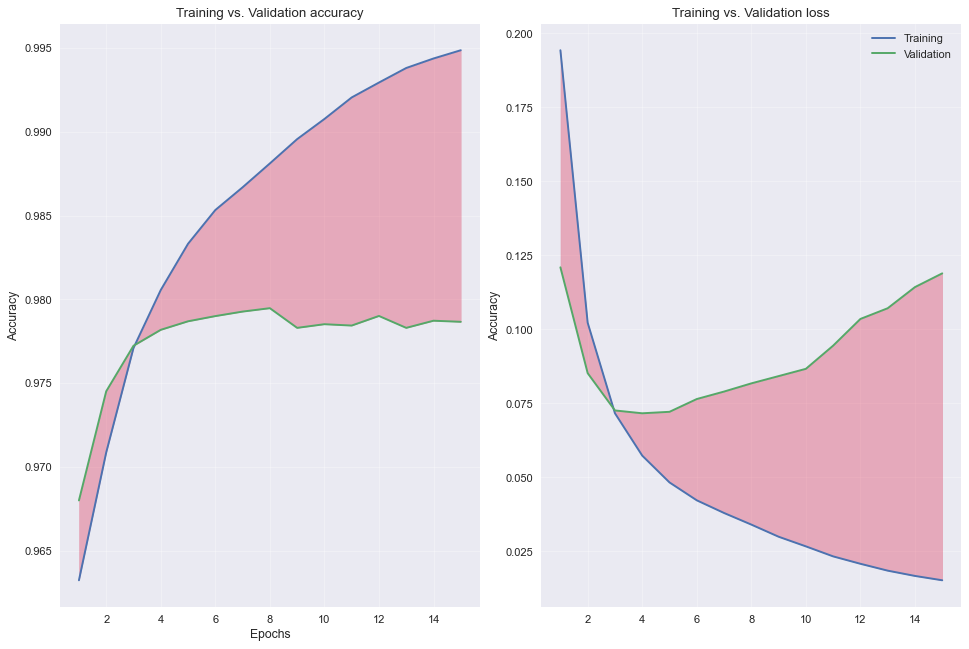

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12,8), dpi=80)
plt.style.use('seaborn')

ax[0].plot(epochs, acc, label = 'Training')
ax[0].plot(epochs, val_acc, label='Validation')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training vs. Validation accuracy')
ax[0].fill_between(epochs,acc,val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')

ax[1].plot(epochs, loss, label = 'Training')
ax[1].plot(epochs, val_loss, label='Validation')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training vs. Validation loss')
ax[1].fill_between(epochs,loss,val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], ylabel='Accuracy')
plt.legend()

# 4 -- NER using NLTK / Spacy

In [87]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy

In [102]:
txt = ' '.join(X[:10])
txt

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . " They marched from the Houses of Parliament to a rally in Hyde Park . Police put the number of marchers at 10,000 while organizers claimed it was 1,00,000 . The protest comes on the eve of the annual conference of Britain \'s ruling Labor Party in the southern English seaside resort of Brighton . The party is divided over Britain \'s participation in the Iraq conflict and the continued deployment of 8,500 British troops in that country . The London march came ahead of anti-war protests today in other cities , including Rome , Paris , and Madrid . The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Iran \'s resumption of lo

In [90]:
tokens = [word_tokenize(t) for t in sent_tokenize(txt)]
tokens[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [93]:
sent = nltk.pos_tag(tokens[0])

In [95]:
pattern = 'NP: {<DT>?<JJ>*<NN>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)

(S
  Thousands/NNS
  of/IN
  demonstrators/NNS
  have/VBP
  marched/VBN
  through/IN
  London/NNP
  to/TO
  protest/VB
  (NP the/DT war/NN)
  in/IN
  Iraq/NNP
  and/CC
  demand/VB
  (NP the/DT withdrawal/NN)
  of/IN
  British/JJ
  troops/NNS
  from/IN
  (NP that/DT country/NN)
  ./.)


In [97]:
from pprint import pprint
iob_tagged = nltk.chunk.tree2conlltags(cs)
pprint(iob_tagged)

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'O'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'B-NP'),
 ('war', 'NN', 'I-NP'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'O'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'B-NP'),
 ('withdrawal', 'NN', 'I-NP'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'O'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'B-NP'),
 ('country', 'NN', 'I-NP'),
 ('.', '.', 'O')]


Hmm... London, Iraq, and British all are tagged "O"

That's bad

In [100]:
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [105]:
txt = X[0]
doc = nlp(txt)
pprint([(x.text, x.label_) for x in doc.ents])

[('Thousands', 'CARDINAL'),
 ('London', 'GPE'),
 ('Iraq', 'GPE'),
 ('British', 'NORP')]


In [107]:
pprint([(x, x.ent_iob_, x.ent_type_) for x in doc])

[(Thousands, 'B', 'CARDINAL'),
 (of, 'O', ''),
 (demonstrators, 'O', ''),
 (have, 'O', ''),
 (marched, 'O', ''),
 (through, 'O', ''),
 (London, 'B', 'GPE'),
 (to, 'O', ''),
 (protest, 'O', ''),
 (the, 'O', ''),
 (war, 'O', ''),
 (in, 'O', ''),
 (Iraq, 'B', 'GPE'),
 (and, 'O', ''),
 (demand, 'O', ''),
 (the, 'O', ''),
 (withdrawal, 'O', ''),
 (of, 'O', ''),
 (British, 'B', 'NORP'),
 (troops, 'O', ''),
 (from, 'O', ''),
 (that, 'O', ''),
 (country, 'O', ''),
 (., 'O', '')]


In [109]:
displacy.render(doc, style='ent')

So!!!! `Spacy` seems to correctly recognize London, Iraq, and British!